In [11]:
import numpy as np
import pandas as pd
import cv2
import tensorflow as tf
import keras
import keras.layers as layers
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import RepeatedKFold, train_test_split
from sklearn.metrics import confusion_matrix

In [12]:
DataSolarModules = pd.read_json('InfraredSolarModules/module_metadata.json').transpose().sort_index()
Classes = DataSolarModules['anomaly_class'].unique()
class_to_number = dict(enumerate(Classes.flatten(), 0))
class_to_number = {v: k for k, v in class_to_number.items()}

In [13]:
def map_to_class(value):
    class_to_number
    return class_to_number.get(value, 'Unknown')

DataSolarModules['class_code'] = DataSolarModules['anomaly_class'].apply(map_to_class)

In [14]:
def read_images_dataframe(dataframe):
    images = []
    for image_path in dataframe['image_filepath']:
        img = cv2.imread("InfraredSolarModules/"+image_path,cv2.IMREAD_GRAYSCALE)
        img = img.reshape(40, 24).astype("float32") / 255
        images.append(img)
    images=np.array(images) 
    return images

def read_labels_dataframe(dataframe):
    labels = []
    for label in dataframe['class_code']:
        labels.append(label)
    labels=np.array(labels) 
    labels.astype("int32")   
    return labels

In [15]:
images = read_images_dataframe(DataSolarModules)
labels = read_labels_dataframe(DataSolarModules)

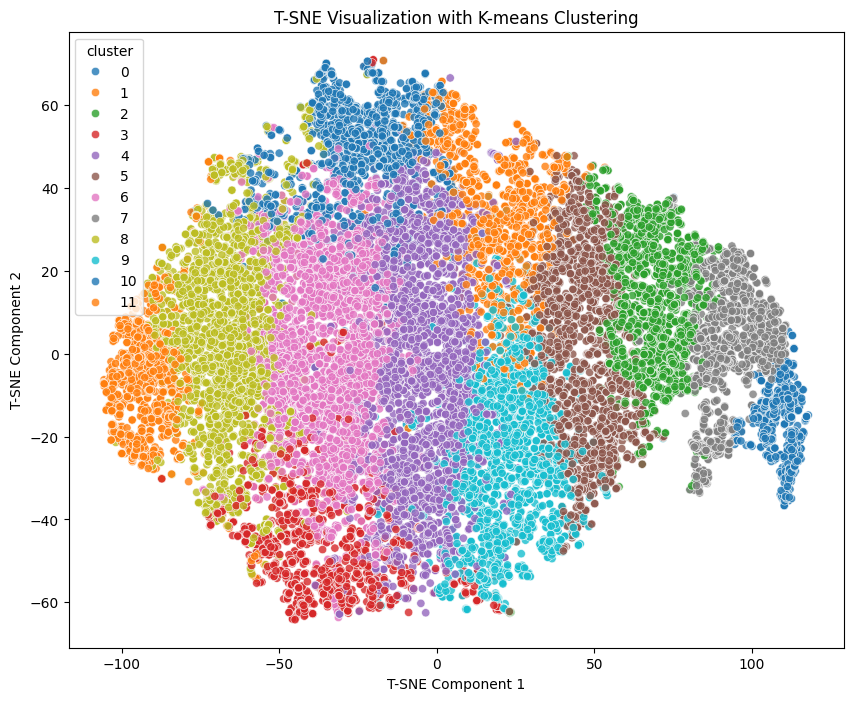

In [16]:
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

# Flatten the images
images_flattened = images.reshape(images.shape[0], -1)

# Perform K-means clustering
kmeans = KMeans(n_clusters=len(Classes), random_state=42)
cluster_labels = kmeans.fit_predict(images_flattened)

# Reduce dimensionality using T-SNE
tsne = TSNE(n_components=2, random_state=42)
tsne_result = tsne.fit_transform(images_flattened)

# Create a DataFrame for visualization
tsne_df = pd.DataFrame(tsne_result, columns=['tsne1', 'tsne2'])
tsne_df['cluster'] = cluster_labels

# Plot the T-SNE visualization with cluster labels
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x='tsne1', y='tsne2',
    hue='cluster',
    palette='tab10',
    data=tsne_df,
    legend='full',
    alpha=0.8
)
plt.title('T-SNE Visualization with K-means Clustering')
plt.xlabel('T-SNE Component 1')
plt.ylabel('T-SNE Component 2')
plt.show()


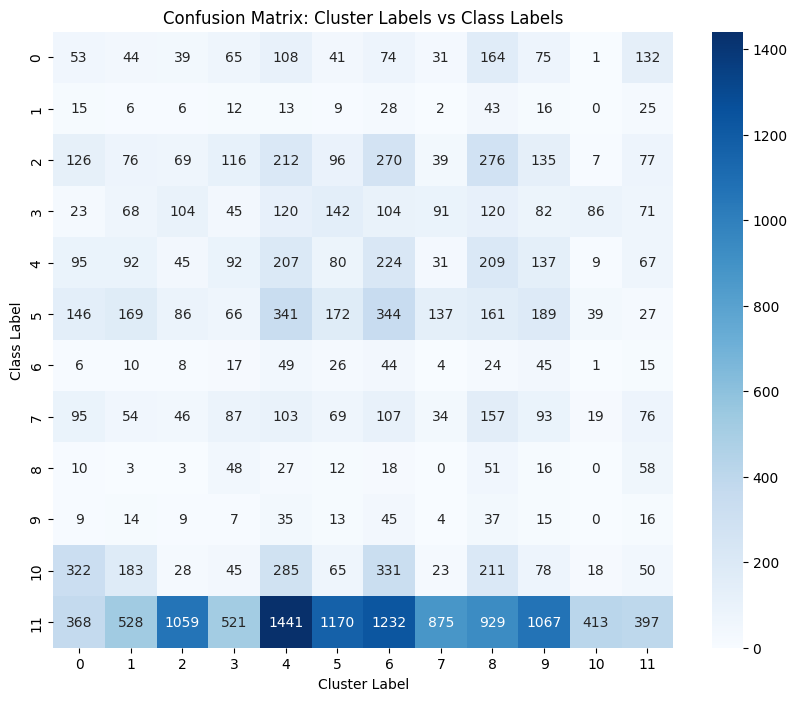

In [17]:
from sklearn.metrics import confusion_matrix

# Create confusion matrix
conf_matrix = confusion_matrix(labels, cluster_labels)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(
    conf_matrix,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=np.unique(cluster_labels),
    yticklabels=np.unique(labels)
)
plt.xlabel('Cluster Label')
plt.ylabel('Class Label')
plt.title('Confusion Matrix: Cluster Labels vs Class Labels')
plt.show()
